no negative sampling  

NN_word = 2000  
num_features = 5

In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
import sys
sys.path.append('/home/admin/github/wordroid.sblo.jp/lib')
from feature_eng import lowcols

In [3]:
import os.path
import sys
import re
import itertools
import csv
import datetime
import pickle
import random
from collections import defaultdict, Counter
import gc

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import gensim
from sklearn.metrics import f1_score, classification_report, confusion_matrix, log_loss
from sklearn.model_selection import train_test_split
import gensim
from keras.preprocessing.sequence import skipgrams
import tensorflow as tf

In [4]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, cmap=cmap, **kwargs)
def scatter(x, y, color, **kwargs):
    plt.scatter(x, y, marker='.')

### create sample data

In [5]:
NN_word = 2000
NN_sentence = 10000
NN_SEG = 7

In [6]:
product_list = [ee+1 for ee in range(NN_word)]
user_list = [ee+1 for ee in range(NN_sentence)]

In [7]:
a, _ = divmod(len(user_list), NN_SEG)
a
cls_user = [int(user_id / (a+1)) for user_id in range(1, 1+len(user_list))]

In [8]:
a, _ = divmod(len(product_list), NN_SEG)
print(a)

cls_prod = [int(prod_id / (a+1)) for prod_id in range(1, 1+len(product_list))]

285


In [9]:
random.seed(0)

X_list = []

for ii in range(len(user_list)):
    cls = cls_user[ii]
    product_group = np.array(product_list)[np.array(cls_prod) == cls]
    nword = random.randint(5, 20)
    prods = random.sample(product_group.tolist(), nword)
    irow = np.zeros((1,NN_word))
    irow[0,np.array(prods)-1] = 1
    X_list.append(irow)

X = np.concatenate(X_list)
print(X.shape)
X

(10000, 2000)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
X_df = pd.DataFrame(X, dtype=int)
X_df.index = ['r'+ee.astype('str') for ee in (np.arange(X_df.shape[0])+1)]
X_df.columns = ['c'+ee.astype('str') for ee in np.arange(X_df.shape[1])+1]
print(X_df.shape)
X_df.head()

(10000, 2000)


c1  c2  c3  c4  c5  c6  c7  c8  c9  c10  ...    c1991  c1992  c1993  \
r1   0   0   0   0   0   0   0   0   0    0  ...        0      0      0   
r2   0   0   0   0   0   0   0   0   0    0  ...        0      0      0   
r3   1   0   0   0   0   0   0   1   0    0  ...        0      0      0   
r4   0   0   0   0   0   0   0   0   0    0  ...        0      0      0   
r5   0   0   0   0   0   0   0   0   0    0  ...        0      0      0   

    c1994  c1995  c1996  c1997  c1998  c1999  c2000  
r1      0      0      0      0      0      0      0  
r2      0      0      0      0      0      0      0  
r3      0      0      0      0      0      0      0  
r4      0      0      0      0      0      0      0  
r5      0      0      0      0      0      0      0  

[5 rows x 2000 columns]

In [11]:
X_df.values.shape

(10000, 2000)

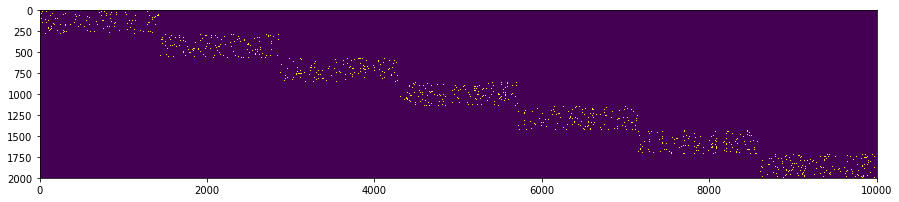

In [12]:
plt.figure(figsize=(15, 15))
plt.imshow(X_df.values.T)

In [13]:
wd2v = lowcols.WD2vec(X_df)
wd2v

In [14]:
num_features = 5

models = wd2v.make_model(num_user=X_df.shape[0], num_product=NN_word, num_features=num_features)
models['model_gk1'].summary()
models['model_user'].summary()
print('\n\n##################### model >>>')
model = models['model']
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_user (InputLayer)      (None, 1)                 0         
_________________________________________________________________
user_embedding (Embedding)   (None, 1, 5)              50000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 5)                 0         
_________________________________________________________________
gkernel1 (GaussianKernel3)   (None, 2000)              10001     
Total params: 60,001
Trainable params: 60,001
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_user (InputLayer)      (None, 1)                 0         
_________________________________________________________________
user_e

In [15]:
wd2v.models['model'].get_layer('user_embedding').get_weights()[0].shape

(10000, 5)

(10000, 5)


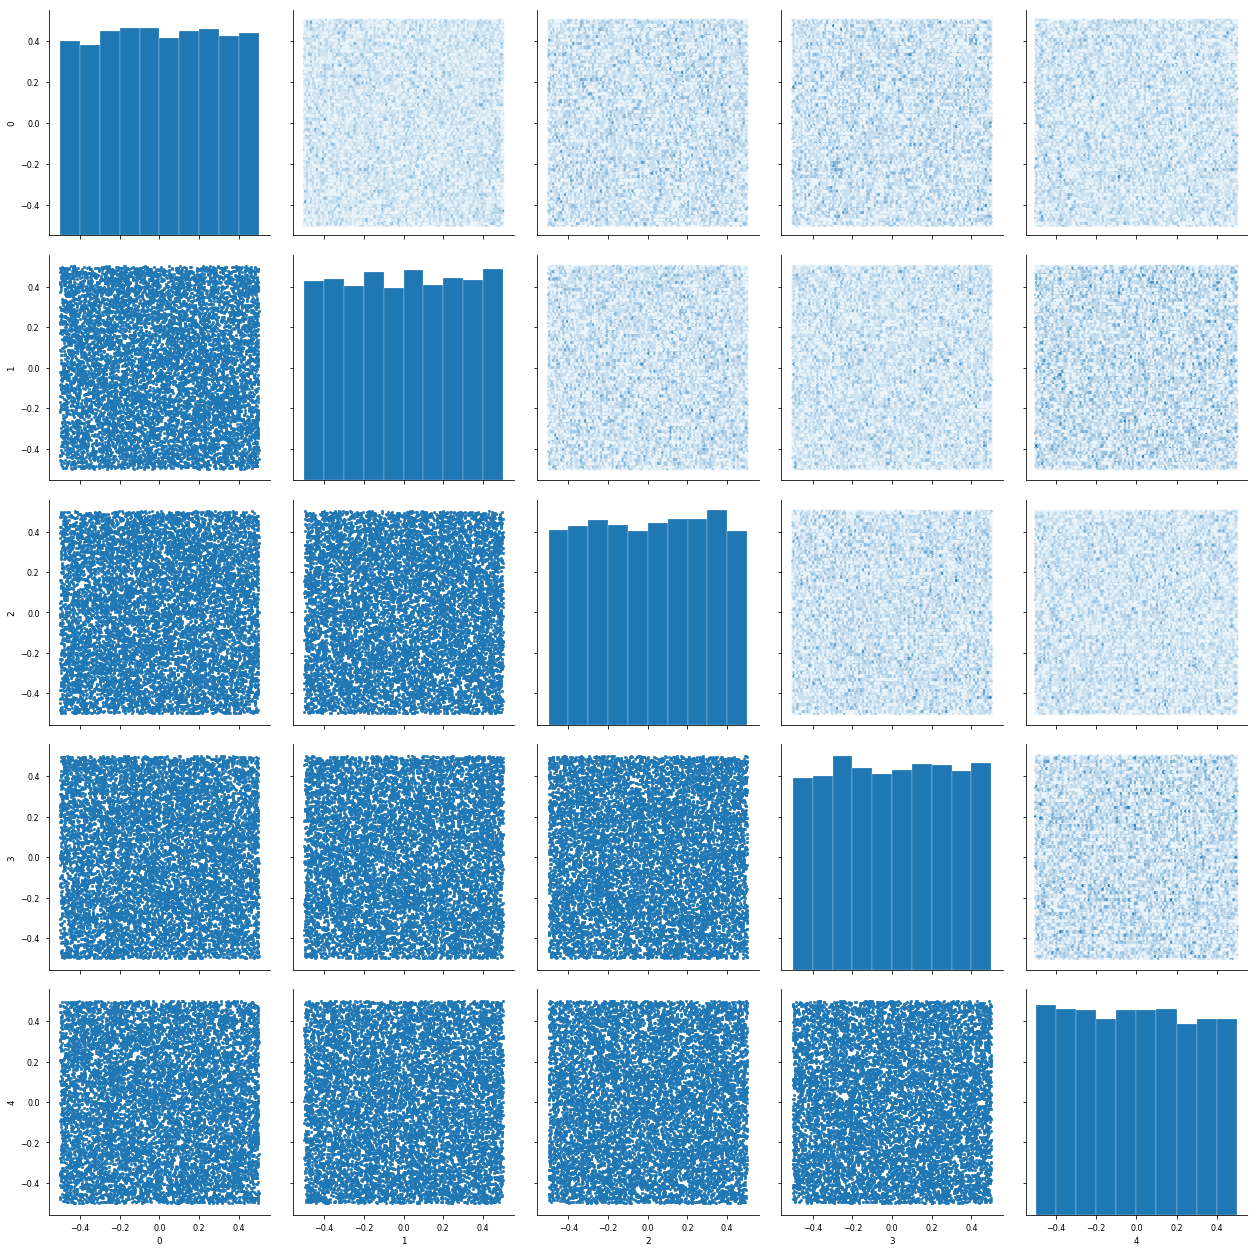

In [16]:
wgt_user = wd2v.get_wgt_byrow()
# wgt_user = model.get_layer('user_embedding').get_weights()[0]
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(2000, 5)


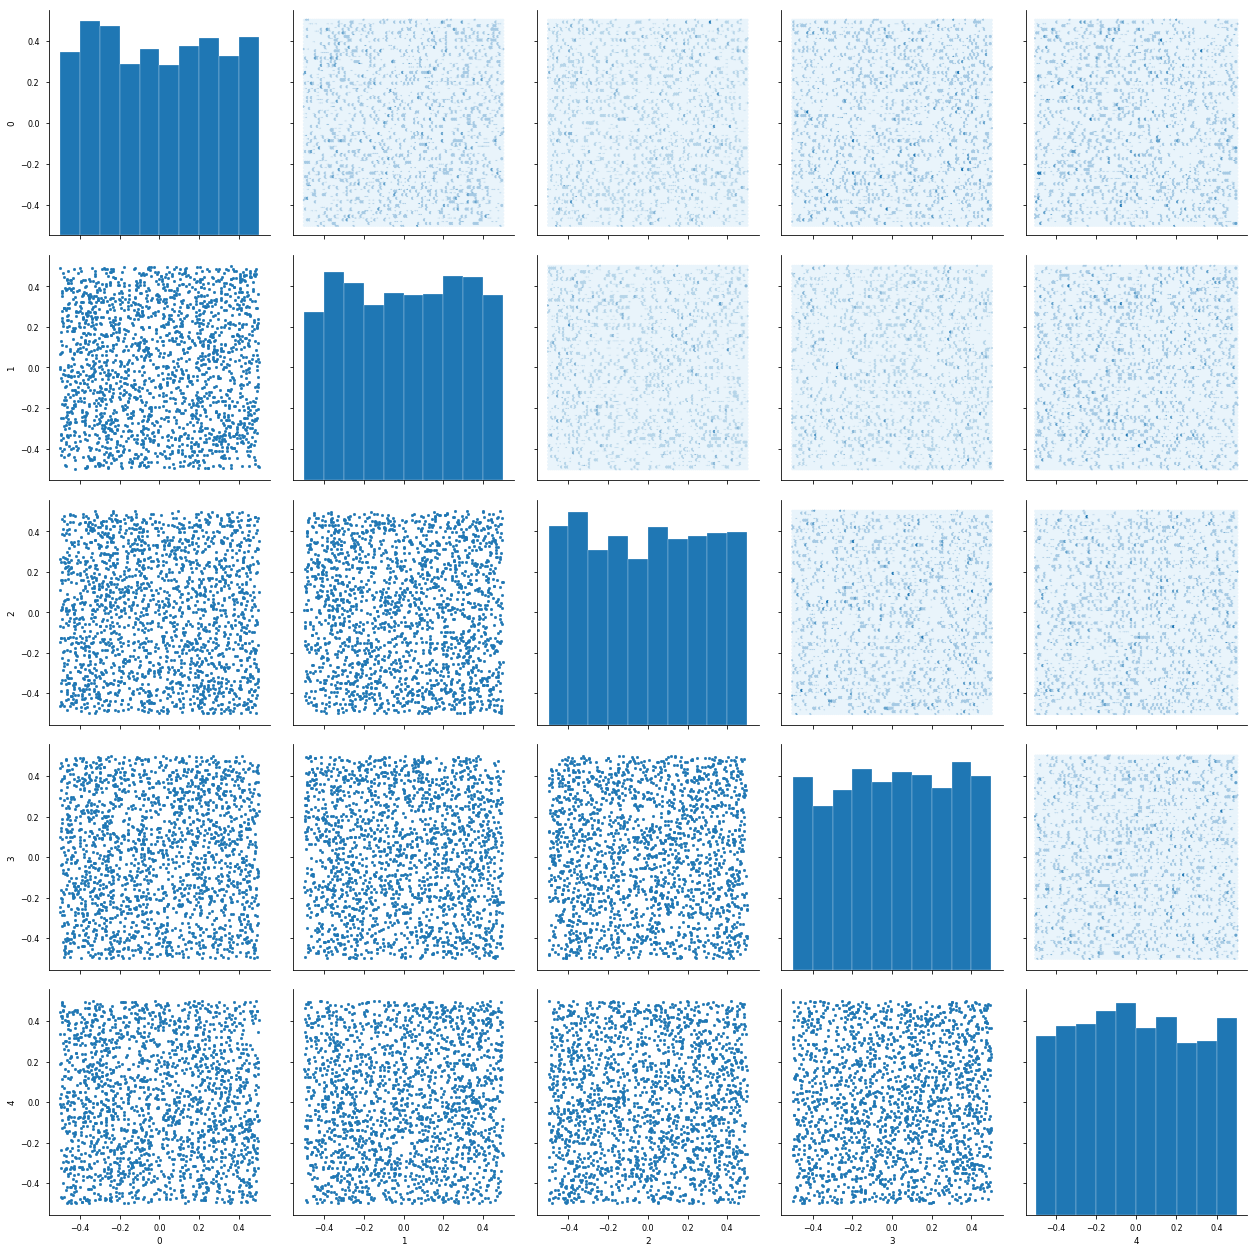

In [17]:
wgt_lm = wd2v.get_wgt_bycol()
print(wgt_lm.shape)
df = pd.DataFrame(wgt_lm[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

### 1

In [18]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau

def lr_schedule(epoch):
    def reduce(epoch, lr):
        if divmod(epoch,4)[1] == 3:
            lr *= (1/8)
        elif divmod(epoch,4)[1] == 2:
            lr *= (1/4)
        elif divmod(epoch,4)[1] == 1:
            lr *= (1/2)
        elif divmod(epoch,4)[1] == 0:
            pass
        return lr
    
    lr0 = 0.01
    epoch1 = 8
    epoch2 = 16
    epoch3 = 16
    epoch4 = 16
    
    if epoch<epoch1:
        lr = lr0
        #lr = reduce(epoch, lr)
    elif epoch<epoch1+epoch2:
        lr = lr0/2
        #lr = reduce(epoch, lr)
    elif epoch<epoch1+epoch2+epoch3:
        lr = lr0/4
        #lr = reduce(epoch, lr)
    elif epoch<epoch1+epoch2+epoch3+epoch4:
        lr = lr0/8
        #lr = reduce(epoch, lr)
    else:
        lr = lr0/16
    
    print('Learning rate: ', lr)
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

callbacks = [lr_scheduler]

hst = wd2v.train(epochs=64, batch_size=32, verbose=2,
           callbacks=callbacks)

Epoch 1/64
Learning rate:  0.01
 - 2s - loss: 0.0896 - acc: 0.9767
Epoch 2/64
Learning rate:  0.01
 - 2s - loss: 0.0425 - acc: 0.9937
Epoch 3/64
Learning rate:  0.01
 - 2s - loss: 0.0396 - acc: 0.9937
Epoch 4/64
Learning rate:  0.01
 - 2s - loss: 0.0383 - acc: 0.9937
Epoch 5/64
Learning rate:  0.01
 - 2s - loss: 0.0377 - acc: 0.9937
Epoch 6/64
Learning rate:  0.01
 - 2s - loss: 0.0374 - acc: 0.9937
Epoch 7/64
Learning rate:  0.01
 - 2s - loss: 0.0370 - acc: 0.9937
Epoch 8/64
Learning rate:  0.01
 - 2s - loss: 0.0364 - acc: 0.9937
Epoch 9/64
Learning rate:  0.005
 - 2s - loss: 0.0353 - acc: 0.9937
Epoch 10/64
Learning rate:  0.005
 - 2s - loss: 0.0342 - acc: 0.9937
Epoch 11/64
Learning rate:  0.005
 - 2s - loss: 0.0328 - acc: 0.9937
Epoch 12/64
Learning rate:  0.005
 - 2s - loss: 0.0311 - acc: 0.9937
Epoch 13/64
Learning rate:  0.005
 - 2s - loss: 0.0291 - acc: 0.9937
Epoch 14/64
Learning rate:  0.005
 - 2s - loss: 0.0273 - acc: 0.9937
Epoch 15/64
Learning rate:  0.005
 - 2s - loss: 0.0

In [19]:
hst_history = hst.history

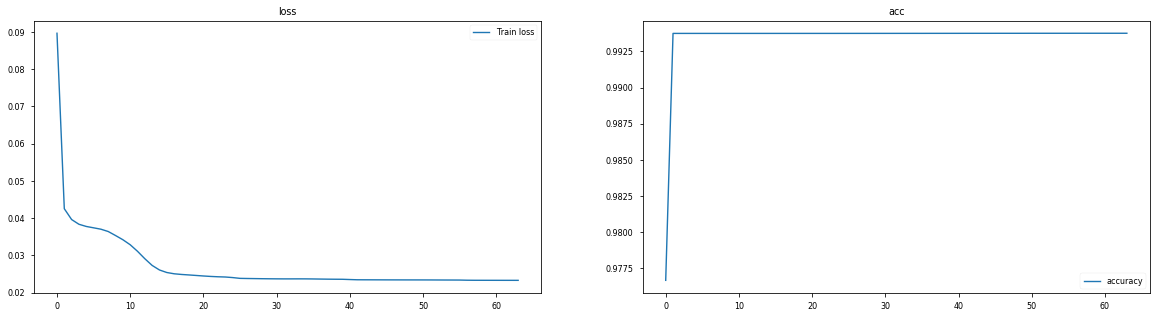

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].set_title('loss')
ax[0].plot(list(range(len(hst_history["loss"]))), hst_history["loss"], label="Train loss")
ax[1].set_title('acc')
ax[1].plot(list(range(len(hst_history["loss"]))), hst_history["acc"], label="accuracy")
ax[0].legend()
ax[1].legend()

(2000, 5)


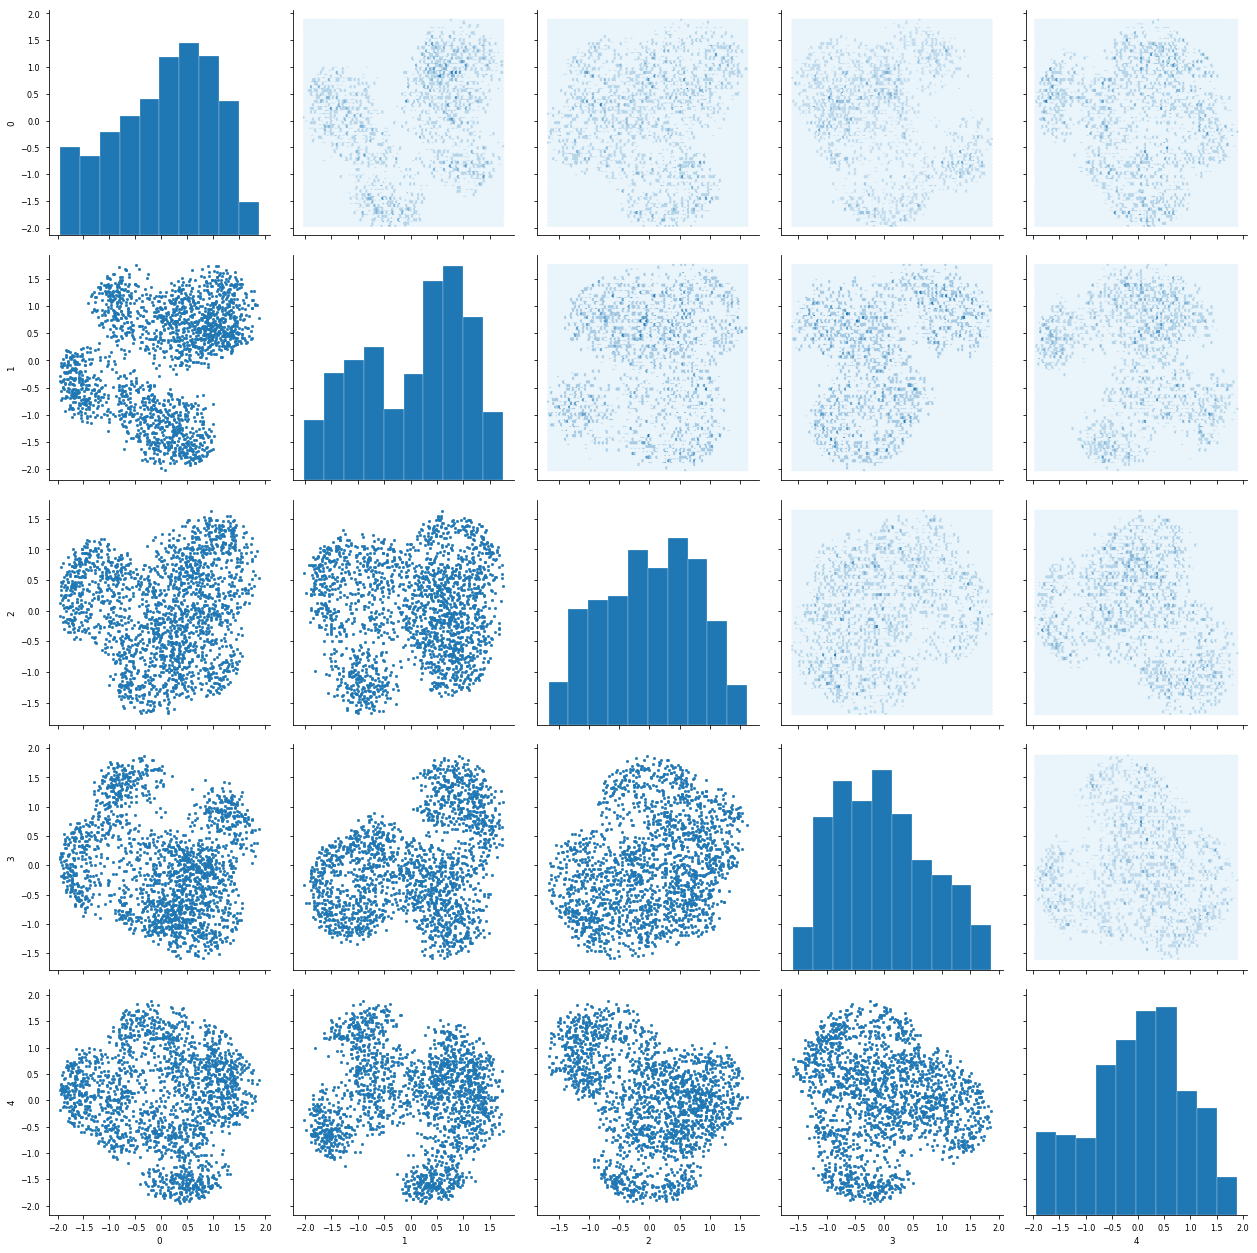

In [21]:
wgt_prod = wd2v.get_wgt_bycol()
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(2000, 5)


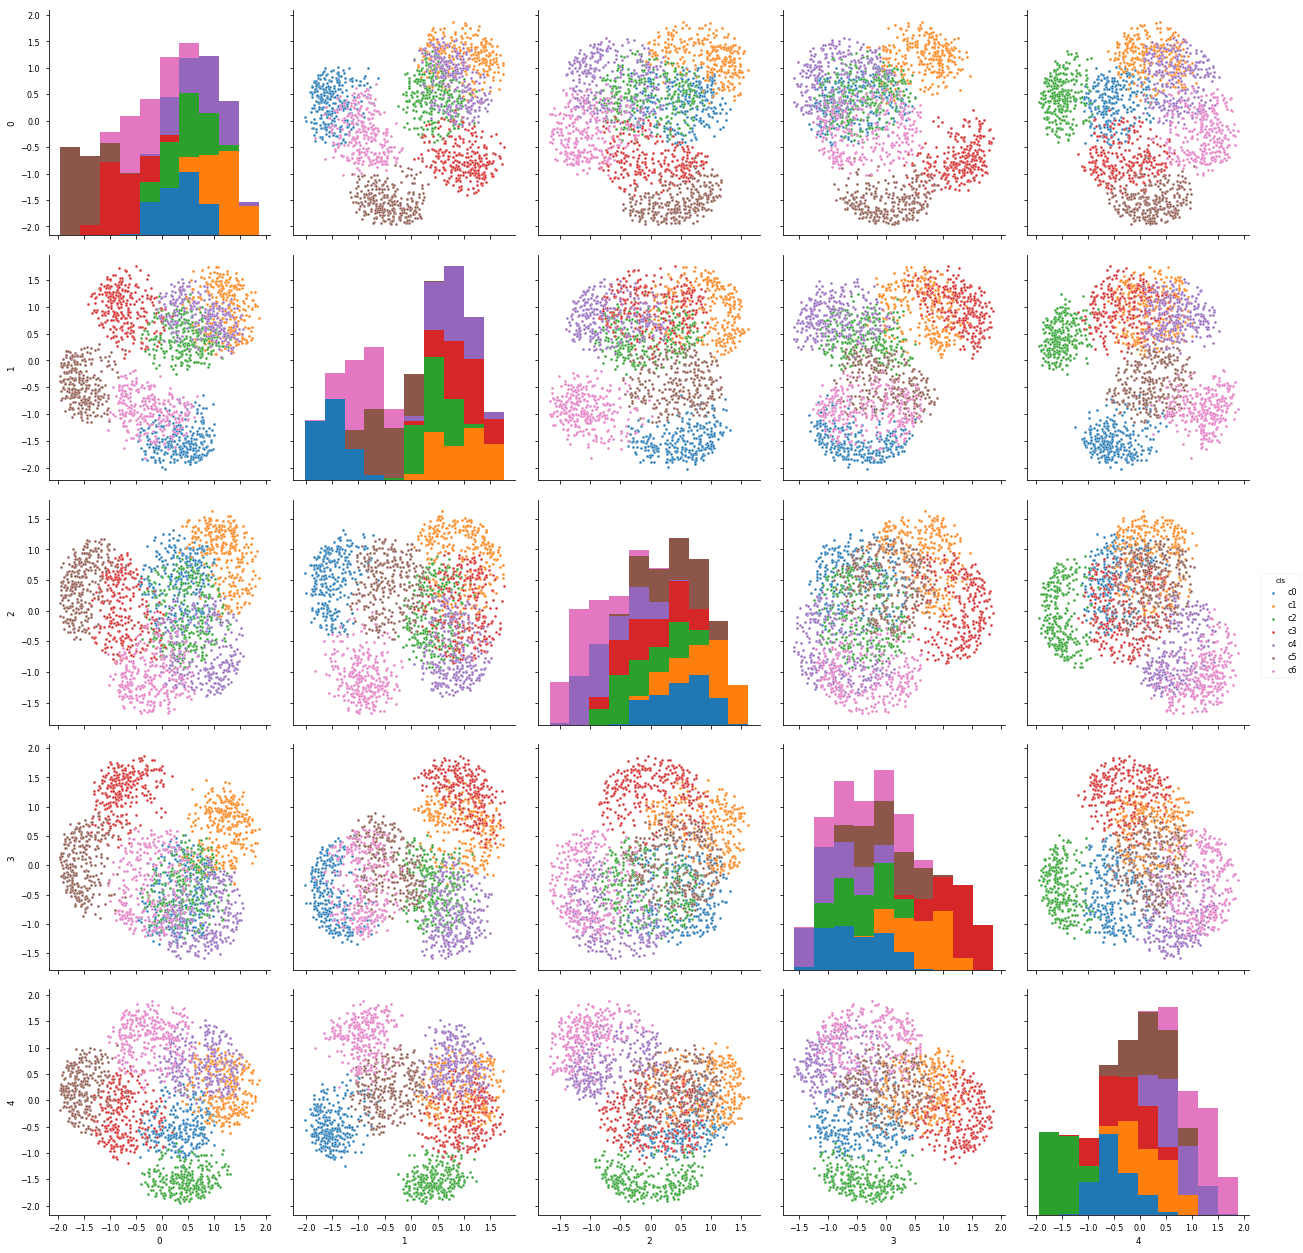

In [22]:
wgt_prod = wd2v.get_wgt_bycol()
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
df['cls'] = ['c'+str(ii) for ii in cls_prod]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

(10000, 5)


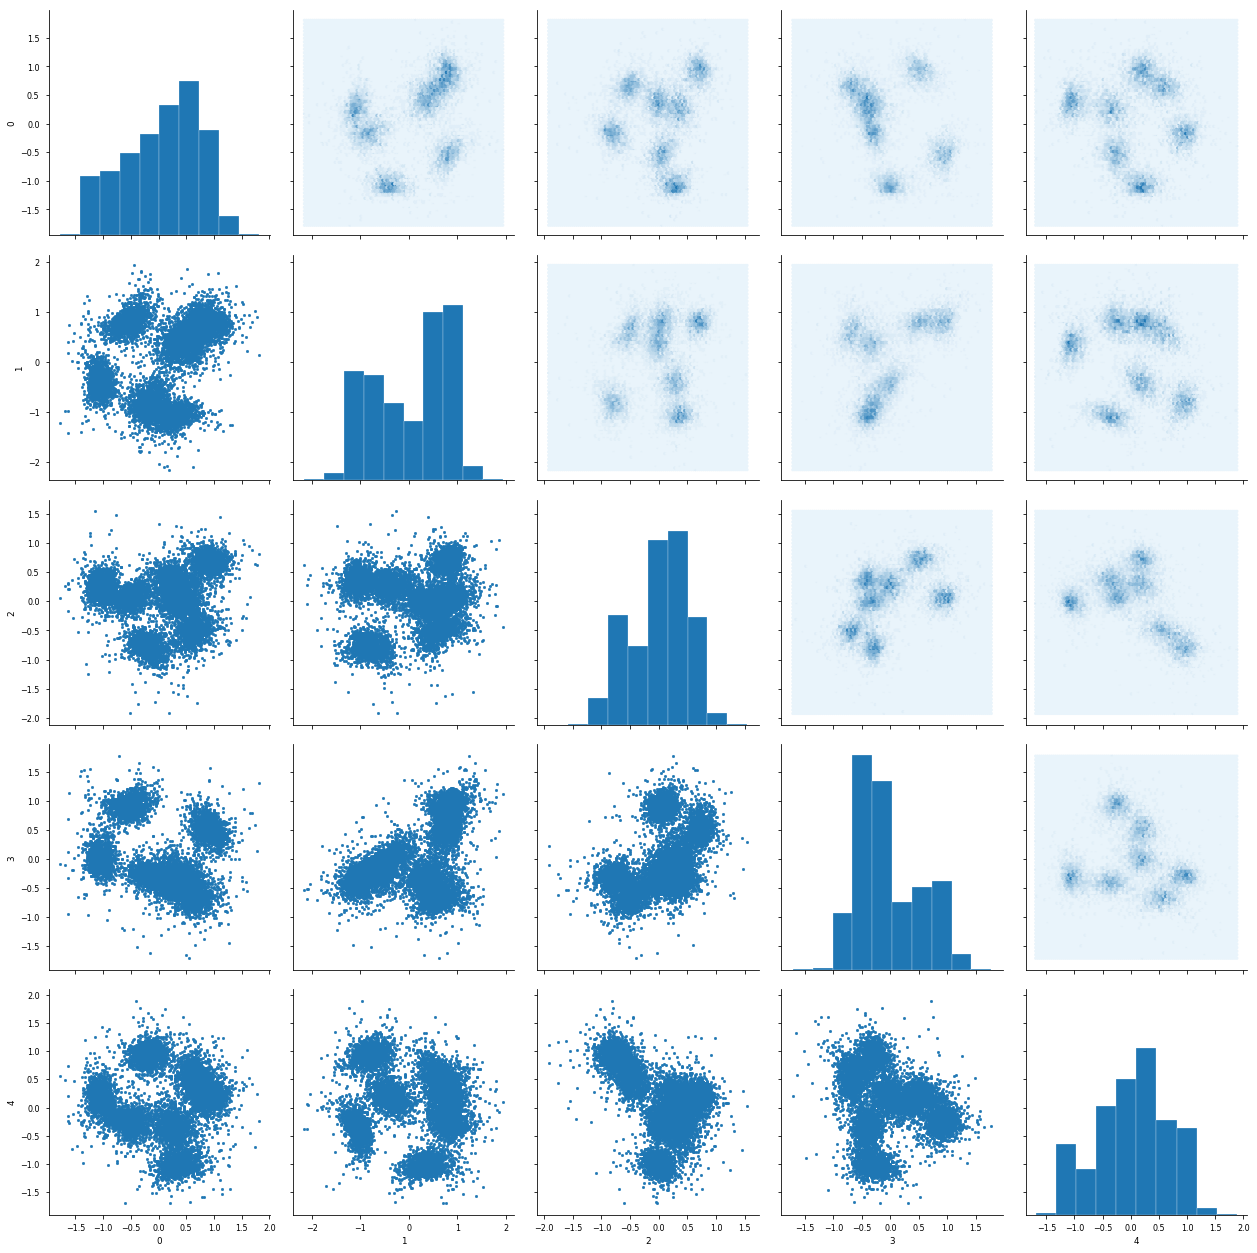

In [23]:
wgt_user = wd2v.get_wgt_byrow()
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(10000, 5)


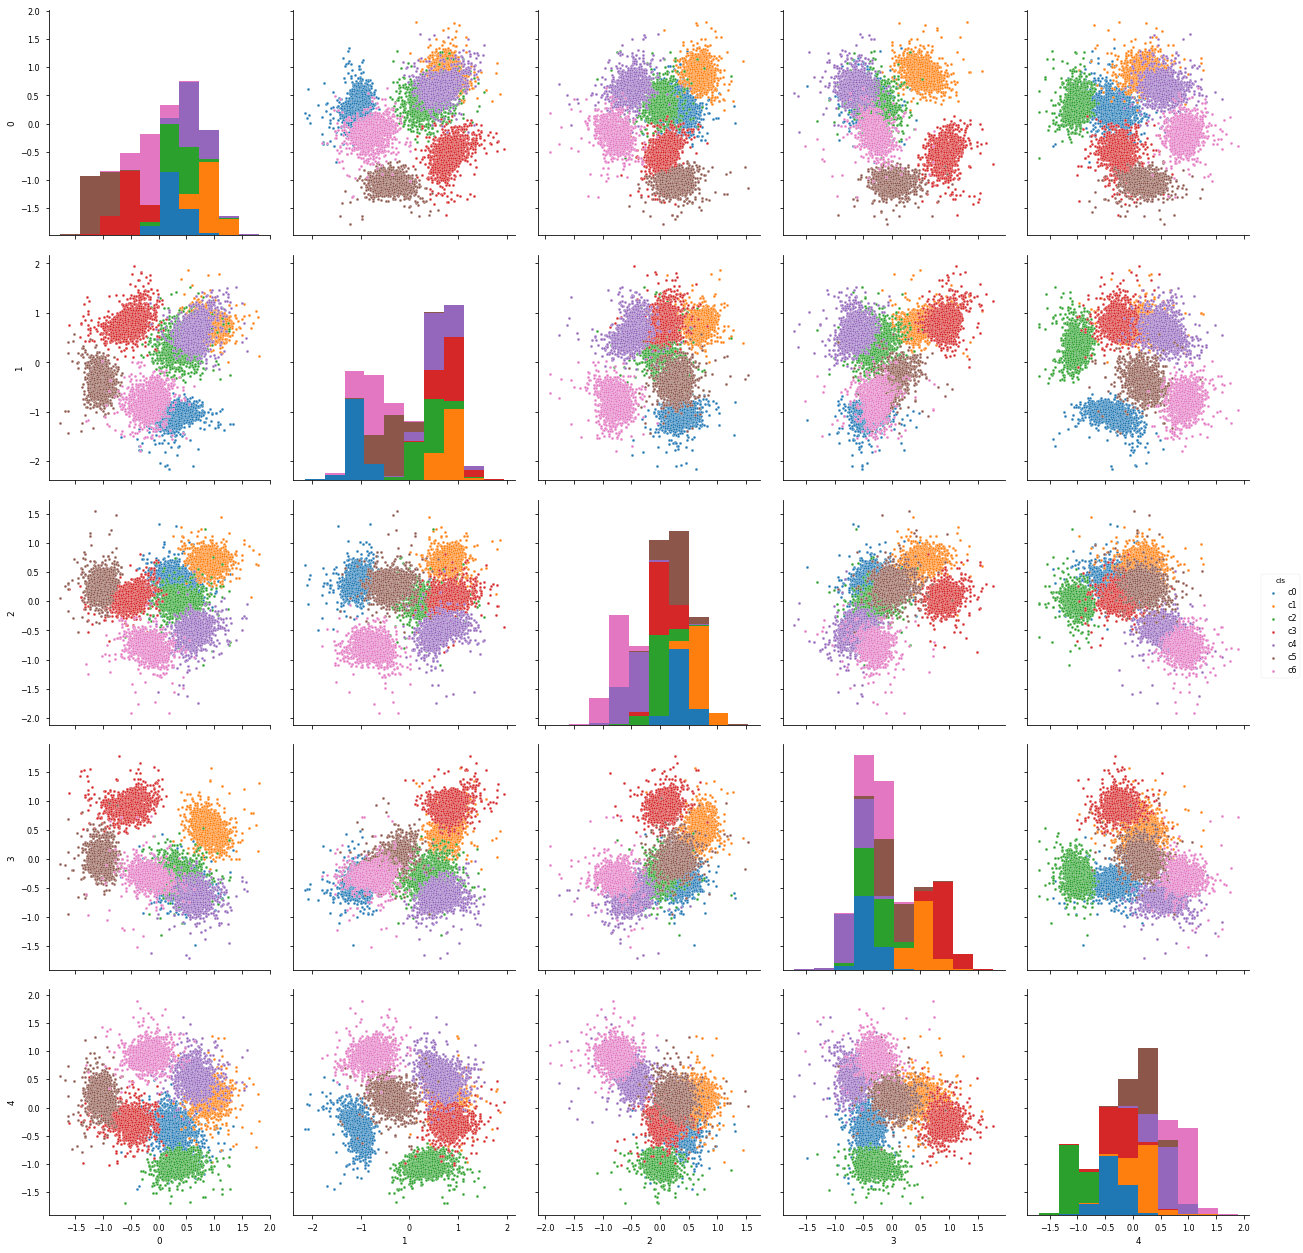

In [24]:
wgt_user = wd2v.get_wgt_byrow()
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
df['cls'] = ['c'+str(ii) for ii in cls_user]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

In [25]:
'''PCA'''
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pca.fit(np.vstack([wgt_prod, wgt_user]))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [26]:
f = pca.transform(np.vstack([wgt_prod, wgt_user]))
f.shape

(12000, 2)

In [27]:
df = pd.DataFrame(f)
df['cls'] = ['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()

0         1 cls
0  0.646822 -0.564473  c0
1  0.967042 -0.111480  c0
2  0.687731 -0.360572  c0
3  0.884754  0.609164  c0
4  1.276260  0.485429  c0

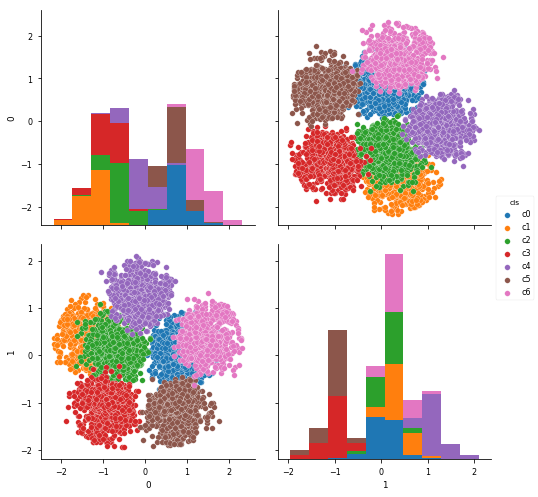

In [28]:
sns.pairplot(df, markers='o', hue='cls', size=3.5, diag_kind='hist')

In [29]:
'''t-SNE'''
from sklearn import manifold
wgt = np.vstack([wgt_prod, wgt_user])
print(wgt.shape)
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(wgt)

(12000, 5)


In [30]:
df = pd.DataFrame(X_tsne)
df['cls'] = ['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()

0          1 cls
0  53.424160 -23.102341  c0
1  50.375263 -14.301706  c0
2  49.545494 -22.557867  c0
3  46.854034 -12.036145  c0
4  54.620094 -11.766507  c0

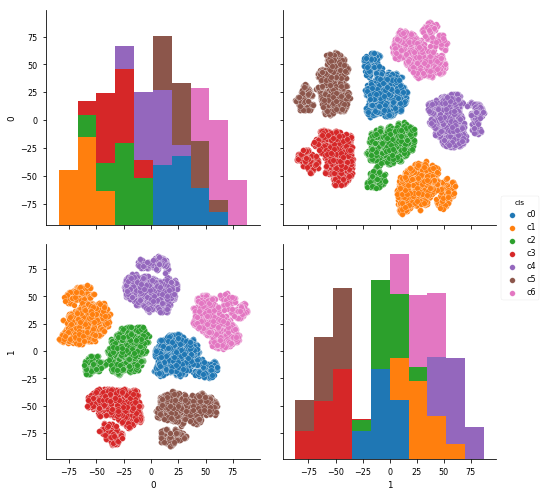

In [31]:
sns.pairplot(df, markers='o', hue='cls', size=3.5, diag_kind='hist')